In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
from helpers import *

In [12]:
df = HSIDataSetDataFrame(pd.read_csv(DATA_DIR / "index.csv"))

In [23]:
sorted(df["Species Short Name"].unique())

['91RH',
 '9d',
 'A128',
 'AH1000',
 'BC15',
 'BQ10',
 'BT6',
 'BTS7',
 'CH12',
 'CL61',
 'CNC12',
 'CS6',
 'CT286',
 'CTX30',
 'DA1',
 'DMV58',
 'DT52',
 'DT66',
 'DT8',
 'DTH155',
 'DTL2',
 'DV108',
 'GL301',
 'GS55R',
 'H229',
 'HD1',
 'HL',
 'HN39',
 'HP28',
 'HQ15',
 'HS1',
 'HT18',
 'KB16',
 'KB27',
 'KB6',
 'KC111',
 'KD18',
 'KL25',
 'KN5',
 'LDA8',
 'LT183',
 'LTH35',
 'MH88',
 'MT151',
 'N54',
 'N97',
 'N98',
 'NBK',
 'NBP',
 'NBT1',
 'NC2',
 'NC7',
 'NCT',
 'ND9',
 'NDC1',
 'NDSLH',
 'NH92',
 'NHN',
 'NKB19',
 'NM142',
 'NN4B',
 'NPQ',
 'NPT1',
 'NPT3',
 'NT16',
 'NTBH',
 'NTHY',
 'NTP',
 'NV1',
 'PC10',
 'PD211',
 'R068',
 'R998KBL',
 'SHPT1',
 'SVN1',
 'TB13',
 'TB14',
 'TC10',
 'TC112',
 'TQ14',
 'TQ36',
 'TV2',
 'TX1',
 'TXHQ',
 'VH8',
 'VP1',
 'VS1',
 'VS5',
 'VS6',
 'VT8']

In [22]:
df.images[1].metadata.to_dict()

{'Species Full Name': 'BC15',
 'Species Short Name': 'BC15',
 'Bundle Number': 2,
 'Folder': 'Data-VIS-20170111-1-room-light-off',
 'File Name': 'BC15-02'}

In [13]:
df

,Species Full Name,Species Short Name,Bundle Number,Folder,File Name
0,BC15,BC15,1,Data-VIS-20170111-1-room-light-off,BC15-01
1,BC15,BC15,2,Data-VIS-20170111-1-room-light-off,BC15-02
2,CT286,CT286,1,Data-VIS-20170111-1-room-light-off,CT286-01
3,CT286,CT286,2,Data-VIS-20170111-1-room-light-off,CT286-02
4,CH12,CH12,1,Data-VIS-20170111-1-room-light-off,CH12-01
...,...,...,...,...,...
175,NT16,NT16,2,Data-VIS-20170117-1-room-light-off,NT16-02
176,TC11-2,TC112,1,Data-VIS-20170117-1-room-light-off,TC11-2-01
177,TC11-2,TC112,2,Data-VIS-20170117-1-room-light-off,TC11-2-02
178,VinhPhuc1,VP1,1,Data-VIS-20170117-1-room-light-off,VinhPhuc1-01


In [14]:
df.index

RangeIndex(start=0, stop=180, step=1)

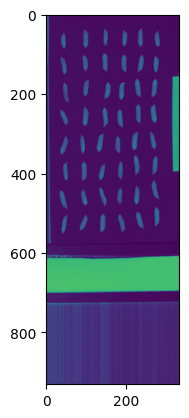

In [15]:
img_num = 13
plt.imshow(df.images[img_num].hsi_calibrated[:, :, 110])

In [16]:
from skimage import filters, morphology, measure, color

for i in range(49, 50):
    img_num = i
    threshold = 0.08
    min_area = 300
    image = df.images[img_num].hsi_calibrated[:, :, 110]
    gray_image = df.images[img_num].hsi_calibrated[:, :, 110]

    binary_mask = image[:580] > threshold
    dialated = morphology.dilation(binary_mask, morphology.disk(3))
    eroded = morphology.erosion(dialated, morphology.disk(3))

    # Perform morphological closing to join nearby regions
    closed = morphology.closing(
        eroded, morphology.disk(3)
    )  # Adjust disk size as needed

    # Remove small objects (regions with area < 100 pixels)
    filtered = morphology.remove_small_objects(closed, min_size=min_area)

    # use regioprops to get the area of each region
    regions = measure.regionprops(measure.label(filtered))
    areas = [region.area for region in regions]
    aspect_ratios = [
        region.major_axis_length / region.minor_axis_length for region in regions
    ]

    # Label connected components
    labeled_regions = measure.label(filtered)

    mask = np.zeros_like(labeled_regions, dtype=bool)
    # Loop through each region and create a mask for regions with aspect ratio <= 5
    for region in regions:
        aspect_ratio = region.major_axis_length / region.minor_axis_length
        if aspect_ratio > 5:  # Remove regions with aspect ratio > 5
            labeled_regions[labeled_regions == region.label] = 0

    # Assign random colours to each region
    colored_regions = color.label2rgb(labeled_regions, kind="overlay")

    # Display results
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # ax[0].imshow(image, cmap="gray")
    # ax[0].set_title(f"Fixed Threshold ({threshold})")
    # ax[0].axis("off")

    # ax[1].imshow(filtered, cmap="gray")
    # ax[1].set_title("After Removing Small Regions (<100 px)")
    # ax[1].axis("off")

    # ax[2].imshow(colored_regions)
    # ax[2].set_title("Segmented Regions with Unique Colours")
    # ax[2].axis("off")
    # np.unique(labeled_regions).shape[0]
    if np.unique(labeled_regions).shape[0] != 49:
        print(i, np.unique(labeled_regions).shape[0])
    # plt.show()

ModuleNotFoundError: No module named 'lazy_loader'

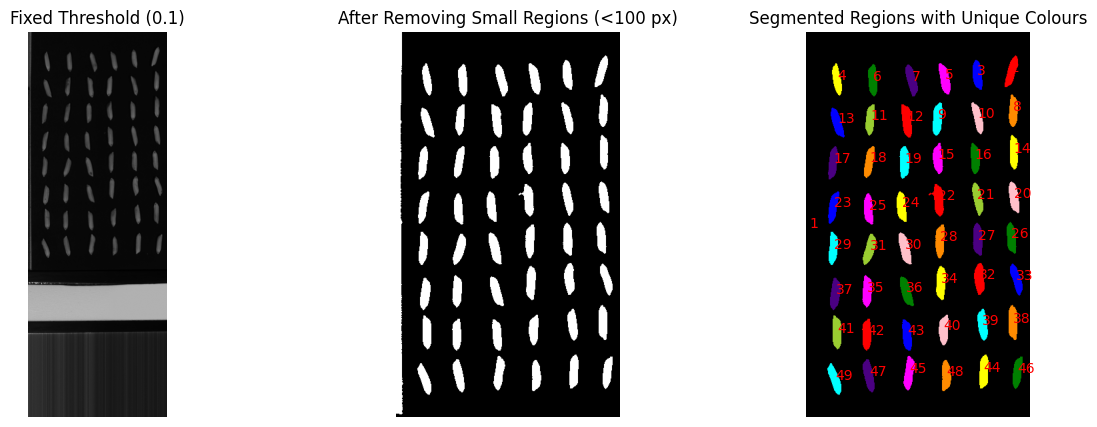

In [ ]:
def segment_image(image_num, threshold=0.08, min_area=300, plot=False):
    image = df.images[img_num].hsi_calibrated[:, :, 110]
    gray_image = df.images[img_num].hsi_calibrated[:, :, 110]

    binary_mask = image[:580] > threshold
    dialated = morphology.dilation(binary_mask, morphology.disk(3))
    eroded = morphology.erosion(dialated, morphology.disk(3))

    # Perform morphological closing to join nearby regions
    closed = morphology.closing(
        eroded, morphology.disk(3)
    )  # Adjust disk size as needed

    # Remove small objects (regions with area < 100 pixels)
    filtered = morphology.remove_small_objects(closed, min_size=min_area)

    # use regioprops to get the area of each region
    regions = measure.regionprops(measure.label(filtered))
    areas = [region.area for region in regions]
    aspect_ratios = [
        region.major_axis_length / region.minor_axis_length for region in regions
    ]

    # Label connected components
    labeled_regions = measure.label(filtered)

    mask = np.zeros_like(labeled_regions, dtype=bool)
    # Loop through each region and create a mask for regions with aspect ratio <= 5
    for region in regions:
        aspect_ratio = region.major_axis_length / region.minor_axis_length
        if aspect_ratio > 5:  # Remove regions with aspect ratio > 5
            labeled_regions[labeled_regions == region.label] = 0

    # Assign random colours to each region
    colored_regions = color.label2rgb(labeled_regions, bg_label=0, kind="overlay")

    # Display results
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title(f"Fixed Threshold ({threshold})")
        ax[0].axis("off")

        ax[1].imshow(filtered, cmap="gray")
        ax[1].set_title("After Removing Small Regions (<100 px)")
        ax[1].axis("off")

        ax[2].imshow(colored_regions)

        for region in regions:
            ax[2].text(
                region.centroid[1], region.centroid[0], region.label, color="red"
            )

        ax[2].set_title("Segmented Regions with Unique Colours")
        ax[2].axis("off")
        plt.show()
    if np.unique(labeled_regions).shape[0] != 49:
        print(i, np.unique(labeled_regions).shape[0])

    return regions, labeled_regions


regions, labeled_regions = segment_image(i, threshold=0.1, plot=True)

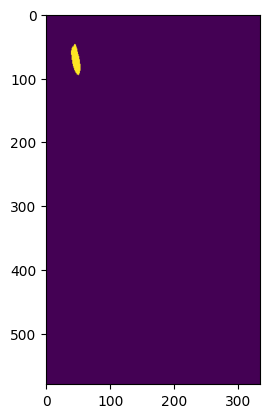

In [ ]:
plt.imshow(labeled_regions == 4)


In [ ]:
from scipy.ndimage import center_of_mass

# Get unique region labels (excluding background 0)
region_labels = np.unique(labeled_regions)
region_labels = region_labels[region_labels > 0]  # Exclude background (0)

# Compute centroids of each region
centroids = np.array(
    center_of_mass(labeled_regions, labels=labeled_regions, index=region_labels)
)

# Sort by Y first (top to bottom), then by X (left to right)
sorted_indices = np.lexsort((centroids[:, 1], centroids[:, 0]))  # Sort by (Y, X)
new_labels = {old: new + 1 for new, old in enumerate(region_labels[sorted_indices])}

# Create new labeled image
renumbered_regions = np.copy(labeled_regions)
for old_label, new_label in new_labels.items():
    renumbered_regions[labeled_regions == old_label] = new_label

# renumbered_regions = renumbered_regions[renumbered_regions > 0]  # Remove background (0)

In [ ]:
np.unique(renumbered_regions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int32)

In [ ]:
import numpy as np
from scipy.ndimage import center_of_mass


def sort_regions_grid(labeled_regions, y_threshold=5):
    region_labels = np.unique(labeled_regions)
    region_labels = region_labels[region_labels > 0]  # Exclude background (0)

    # Compute centroids
    centroids = np.array(
        center_of_mass(labeled_regions, labels=labeled_regions, index=region_labels)
    )

    # Sort centroids by Y-coordinates
    sorted_y_indices = np.argsort(centroids[:, 0])
    centroids = centroids[sorted_y_indices]
    region_labels = region_labels[sorted_y_indices]

    # Cluster regions into rows based on Y proximity
    rows = []
    current_row = [region_labels[0]]

    for i in range(1, len(region_labels)):
        if centroids[i, 0] - centroids[i - 1, 0] > y_threshold:
            rows.append(current_row)
            current_row = []
        current_row.append(region_labels[i])

    rows.append(current_row)  # Append last row

    # Sort each row by X-coordinates
    sorted_labels = []
    for row in rows:
        row_centroids = centroids[np.isin(region_labels, row)]
        sorted_x_indices = np.argsort(row_centroids[:, 1])
        sorted_labels.extend(np.array(row)[sorted_x_indices])

    # Renumber labels
    new_labels = {old: new + 1 for new, old in enumerate(sorted_labels)}
    renumbered_regions = np.copy(labeled_regions)
    for old_label, new_label in new_labels.items():
        renumbered_regions[labeled_regions == old_label] = new_label

    return renumbered_regions


# Usage
renumbered_regions = sort_regions_grid(labeled_regions, y_threshold=25)

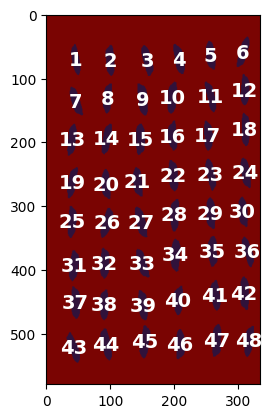

In [ ]:
plt.imshow(renumbered_regions == 0, cmap="turbo")
for i in range(1, 49):
    region = renumbered_regions == i
    # compute the center of mass
    center = np.array(center_of_mass(region))
    # print(f"Region {i}: {center}")
    # plt.imshow(renumbered_regions == i)
    # plot centre
    # plt.scatter(center[1], center[0], color="red", s=100, marker="x")
    plt.text(
        center[1],
        center[0],
        str(i),
        color="white",
        fontsize=14,
        fontdict={"weight": "bold"},
        ha="center",
        va="center",
    )
plt.show()

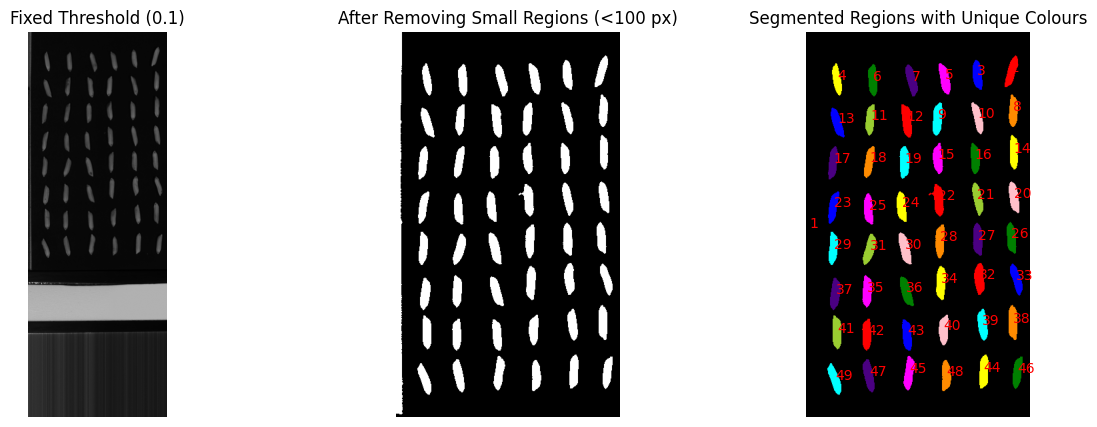

In [ ]:
for i in range(10, 11):
    segment_image(i, threshold=0.1, plot=True)

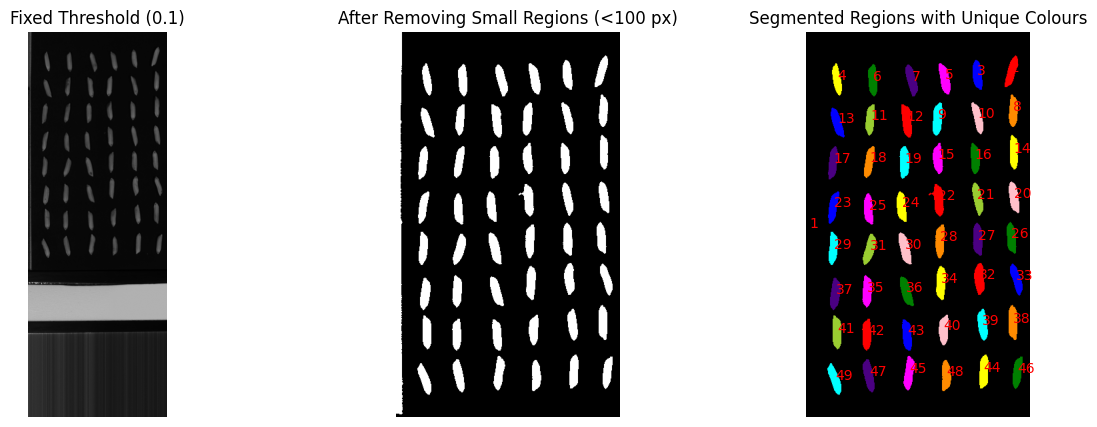

In [ ]:
regions = segment_image(i, threshold=0.1, plot=True)

In [ ]:
def extract_masks(labeled_regions):
    region_labels = np.unique(labeled_regions)
    region_labels = region_labels[region_labels > 0]  # Exclude background (0)

    masks = {
        label: (labeled_regions == label).astype(np.uint8) for label in region_labels
    }
    return masks  # Dictionary {label: mask}


masks = extract_masks(renumbered_regions)

In [ ]:
masks[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(580, 336), dtype=uint8)

In [ ]:
# plt.imshow(df.images[img_num].hsi_calibrated[masks[1]])a


In [ ]:
masks[1].shape
# plt.imshow(masks[1], cmap="gray")

(580, 336)

In [ ]:
df.images[img_num].hsi_calibrated.shape

(931, 336, 256)

In [ ]:
img = df.images[img_num].hsi_calibrated[:580]

In [ ]:
img.shape

(580, 336, 256)

In [ ]:
masks[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(580, 336), dtype=uint8)

(60, 60, 256)

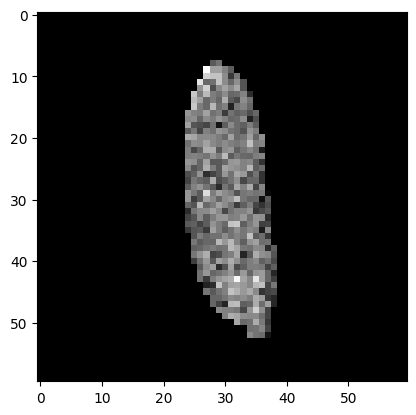

In [ ]:
def extract_bounded_seed(specimg, masks, renumbered_regions, region_id, bbox_size = 30):
    res = specimg * masks[region_id][:, :, np.newaxis]
    centroid = center_of_mass(renumbered_regions == region_id)

    # Get a bounding box
    bbox = (np.add(centroid, -bbox_size).astype(int), np.add(centroid, bbox_size).astype(int))
    # print(bbox)
    # print(centroids[1])
    # Crop it
    res = res[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]

    return res


res = extract_bounded_seed(img, masks, renumbered_regions, 5)

plt.imshow(res[:, :, 10], cmap="gray")
res.shape

In [ ]:
regions = np.max(renumbered_regions)

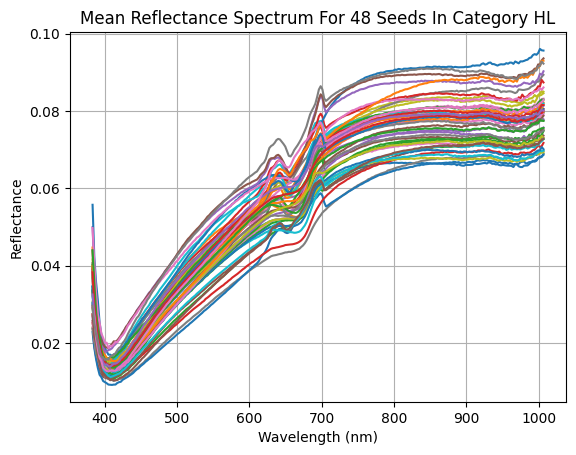

In [ ]:
spectra = [np.mean(res, axis=(0, 1)) for res in [extract_bounded_seed(img, masks, renumbered_regions, i+1) for i in range(regions)]]
plt.figure()

for i in range(regions):
    plt.plot(df.images[img_num].wavelengths, spectra[i])

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title(f"Mean Reflectance Spectrum For {regions} Seeds In Category {df.images[img_num].metadata['Species Short Name']}")
plt.grid(True)
plt.show()

In [ ]:
df.images[img_num].metadata

/opt/software/uoa/spack/linux-rhel8-x86_64/gcc-12.3.0/python-3.11.7-zecrrwd3qxojzwtuomzbud5ft2ovtz7n/lib/python3.11/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
[autoreload of matplotlib.colorizer failed: Traceback (most recent call last):
  File "/uoa/home/c01vo24/sharedscratch/TeamB-rice-hsi-hackathon-2025/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 283, in check
  File "/uoa/home/c01vo24/sharedscratch/TeamB-rice-hsi-hackathon-2025/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
  File "/opt/software/uoa/spack/linux-rhel8-x86_64/gcc-12.3.0/python-3.11.7-zecrrwd3qxojzwtuomzbud5ft2ovtz7n/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<froz

AttributeError: 'Series' object has no attribute 'Folder'

: 

In [ ]:
df.images[img_num].metadata["Species Short Name"]

'HL'

In [ ]:
Dict(df.images[img_num].metadata)